In [3]:
import os
import math
from datetime import datetime, timedelta

import matplotlib as mpl
from matplotlib import pyplot, gridspec
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter

from metpy import plots, calc
from metpy.units import units

import numpy as np

import pyart

import profile_io as io


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [4]:
def plot_skewT(profile1, profile2, profile3, title,
                subplot_idx,
                fig,
                comp_pressure=None, comp_dewpoint=None, top_pressure=200, bottom_pressure=1050,
                profile1_barb_skip=40, profile2_barb_skip=10, profile3_barb_skip=1,
                vert_dim='model_level_number', **kwargs):

    """
    Plot a skew T plot with optional profile.

    Arguments:
        - **kwargs: Optional extra arguments to cape_func or to metpy.plots.SkewT.
    """

    # New blank skew T plot.
    skew = plots.SkewT(fig, subplot=subplot_idx, **kwargs)

    # Plot environmental temperature.
    skew.plot(pressure = profile1['pres'], t = profile1['tmpc'], 
            color = 'r', linewidth = 1.5)
    skew.plot(pressure = profile2['pres'], t = profile2['tmpc'], 
            color = 'r', linewidth = 1)
    if profile3:
        skew.plot(pressure = profile3['pres'], t = profile3['tmpc'], 
                color = 'k', linewidth = 1)

    # Plot dewpoint.
    skew.plot(pressure = profile1['pres'], t = profile1['dwpc'],
            color = 'g', linewidth = 1.5)
    skew.plot(pressure = profile2['pres'], t = profile2['dwpc'],
            color = 'g', linewidth = 1)
    if profile3:
        skew.plot(pressure = profile3['pres'], t = profile3['dwpc'], 
                color = 'k', linewidth = 1, linestyle = ':')
    
    # Plot wind.
    skew.plot_barbs(pressure=profile1['pres'][::profile1_barb_skip],
                    u=profile1['wind_u'][::profile1_barb_skip],
                    v=profile1['wind_v'][::profile1_barb_skip],
                    xloc=0.76, y_clip_radius=0.01, linewidth = 1.2, color = 'r')

    skew.plot_barbs(pressure=profile2['pres'][::profile2_barb_skip],
                    u=profile2['wind_u'][::profile2_barb_skip],
                    v=profile2['wind_v'][::profile2_barb_skip],
                    xloc=0.84, y_clip_radius=0.01, linewidth = 0.5, color = 'r')    
    if profile3:    
        skew.plot_barbs(pressure=profile3['pres'][::profile3_barb_skip],
                        u=profile3['wind_u'][::profile3_barb_skip],
                        v=profile3['wind_v'][::profile3_barb_skip],
                        xloc=0.96, y_clip_radius=0.01, linewidth = 0.5, color = 'k')                    

    # Add labels.
    pyplot.ylim(bottom_pressure, top_pressure)
    pyplot.xlim(-10, 40)
    pyplot.xlabel('Temperature ($^{\circ}$C)')
    pyplot.ylabel('Pressure (hPa)')
    pyplot.title(title)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_dt_idx(target_dt, dt_list):
    time_diff = []
    for tempdt in dt_list:
        time_diff.append(abs((target_dt-tempdt).total_seconds()))
    return np.argmin(time_diff)

def degrees2meters(degrees, radius=6371000.0):
    """
    Convenience function to convert (great circle) degrees to meters
    assuming a perfectly spherical Earth.

    :type degrees: float
    :param degrees: Distance in (great circle) degrees
    :type radius: float, optional
    :param radius: Radius of the Earth used for the calculation.
    :rtype: float
    :return: Distance in meters as a floating point number.

    .. rubric:: Example

    >>> from obspy.geodetics import degrees2kilometers
    >>> degrees2kilometers(1)
    111.19492664455873
    """
    return degrees * (2.0 * radius * math.pi / 360.0)


(900.0, 400.0)

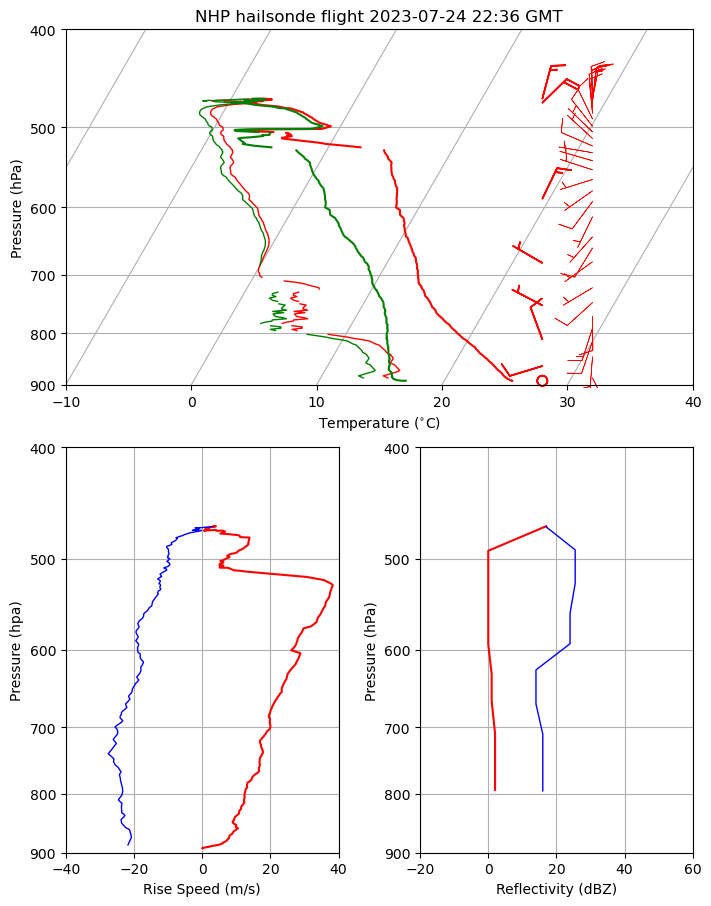

In [5]:
bottom_pressure = 900
top_pressure = 400
radar_id = 2
row_to_split_profile = 321 #profile 1 446; profile 2 321
gmt_offset = -6
radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset'


#read data
filename = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/2023-07-24_1636_9935.raw_flight_history.csv'
with_balloon_profile, no_balloon_profile, metadata = io.decode_raw_flight_history(filename, split=row_to_split_profile)

#create figure and axes
fig = pyplot.figure(constrained_layout = True, figsize = (7, 9))
gs = fig.add_gridspec(2, 2)

#get location and time
snd_lat = with_balloon_profile['lat'][0]
snd_lon = with_balloon_profile['lon'][0]
snd_start_dt = datetime.strptime(os.path.basename(filename)[0:15], '%Y-%m-%d_%H%M') - timedelta(hours = gmt_offset) #MUST BE UTC+0 TIME

#get access-g data
# accessg_profile = io.get_accessg_profile(snd_start_dt, snd_lat, snd_lon)

#plot skewT profiles
plot_skewT(with_balloon_profile, no_balloon_profile, None,
                f'NHP hailsonde flight {snd_start_dt.strftime("%Y-%m-%d %H:%M")} GMT',
                subplot_idx=gs[0, :],
                fig=fig,
                top_pressure=top_pressure, bottom_pressure=bottom_pressure,
                vert_dim='altitude above MSL (m)')

#plot rise speed
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_formatter(NullFormatter())
ax1.plot(with_balloon_profile['rise'], with_balloon_profile['pres'], color='r', linewidth=1.5)
ax1.plot(no_balloon_profile['rise'], no_balloon_profile['pres'], color='b', linewidth=1)
ax1.set_xlabel('Rise Speed (m/s)')
ax1.set_ylabel('Pressure (hpa)')
ax1.grid()
ax1.set_xlim((-40,40))
ax1.set_ylim((bottom_pressure, top_pressure))

#plot reflectivity profile

#init plot
ax2 = fig.add_subplot(gs[1, 1])
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_formatter(NullFormatter())

#define height levels
alt_refl_profile = np.arange(1000,7500,500)

#init ascending (1) and descending (2) radar datasets
pres_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
lat_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
lon_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
time_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
radar_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)

pres_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
lat_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
lon_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
time_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
radar_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)

#filter out nan values
nan_mask1 = np.isnan(with_balloon_profile['lat'])
filt_hght_profile1 = with_balloon_profile['hght'][~nan_mask1]
nan_mask2 = np.isnan(no_balloon_profile['lat'])
filt_hght_profile2 = no_balloon_profile['hght'][~nan_mask2]
for i, alt in enumerate(alt_refl_profile):
    idx = find_nearest_idx(filt_hght_profile1, alt)
    pres_refl_profile1[i] = np.array(with_balloon_profile['pres'])[~nan_mask1][idx]
    lat_refl_profile1[i] = np.array(with_balloon_profile['lat'])[~nan_mask1][idx]
    lon_refl_profile1[i] = np.array(with_balloon_profile['lon'])[~nan_mask1][idx]
    time_refl_profile1[i] = np.array(with_balloon_profile['time'])[~nan_mask1][idx]

    idx = find_nearest_idx(filt_hght_profile2, alt)
    pres_refl_profile2[i] = np.array(no_balloon_profile['pres'])[~nan_mask2][idx]
    lat_refl_profile2[i] = np.array(no_balloon_profile['lat'])[~nan_mask2][idx]
    lon_refl_profile2[i] = np.array(no_balloon_profile['lon'])[~nan_mask2][idx]
    time_refl_profile2[i] = np.array(no_balloon_profile['time'])[~nan_mask2][idx]
    

#load radar data
#snd_end_dt = snd_start_dt + timedelta(seconds=time_refl_profile2[-1])
radars, radar_dt_list = io.load_nhp_radar_data(radar_vols_path, 360)

for i in range(len(alt_refl_profile)):
    profile1_target_dt = snd_start_dt + timedelta(seconds = time_refl_profile1[i])
    profile2_target_dt = snd_start_dt + timedelta(seconds = time_refl_profile2[i])

    profile1_radar_idx = find_nearest_dt_idx(profile1_target_dt, radar_dt_list)
    profile2_radar_idx = find_nearest_dt_idx(profile2_target_dt, radar_dt_list)


    gate_lon = radars[profile1_radar_idx].gate_longitude['data']
    gate_lat = radars[profile1_radar_idx].gate_latitude['data']
    gate_alt = radars[profile1_radar_idx].gate_altitude['data']
    gate_refl = radars[profile1_radar_idx].fields['reflectivity_horizontal']['data'].data

    dist = np.sqrt((degrees2meters(gate_lat - lat_refl_profile1[i]))**2 + (degrees2meters(gate_lon - lon_refl_profile1[i]))**2 + (gate_alt - alt_refl_profile[i])**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_refl.shape)
    radar_refl_profile1[i] = gate_refl[min_dist_idx]

    gate_lon = radars[profile2_radar_idx].gate_longitude['data']
    gate_lat = radars[profile2_radar_idx].gate_latitude['data']
    gate_alt = radars[profile2_radar_idx].gate_altitude['data']
    gate_refl = radars[profile2_radar_idx].fields['reflectivity_horizontal']['data'].data

    dist = np.sqrt((degrees2meters(gate_lat - lat_refl_profile2[i]))**2 + (degrees2meters(gate_lon - lon_refl_profile2[i]))**2 + (gate_alt - alt_refl_profile[i])**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_refl.shape)
    radar_refl_profile2[i] = gate_refl[min_dist_idx]  


ax2.plot(radar_refl_profile1, pres_refl_profile1, color='r', linewidth=1.5)
ax2.plot(radar_refl_profile2, pres_refl_profile2, color='b', linewidth=1)
ax2.set_xlabel('Reflectivity (dBZ)')
ax2.set_ylabel('Pressure (hPa)')
ax2.grid()
ax2.set_xlim((-20,60))
ax2.set_ylim((bottom_pressure, top_pressure))

#pyplot.savefig(filename + '.png')